# Load Data

In [1]:
import load_data
df = load_data.load_county_level(data_dir='data')

loading county-level data...
loaded and merged COVID-19 cases/deaths data successfully


In [2]:
keys = df.keys()

import numpy as np
import torch as th
attr_cols = []

# Set the variable to True if we want to specify features ourselves.
use_specified_fields = False

if use_specified_fields:
    f = open("fields.txt", "r")
    fields = f.readlines()
    for field in fields:
        field = field.rstrip()
        arr = np.array(df[field])
        if arr.dtype == np.float32 or arr.dtype == np.float64:
            attr_cols.append(np.array(arr, dtype=np.float32))
else:
    for i in range(6, 86):
        arr = np.array(df[keys[i]])
        if arr.dtype == np.float32 or arr.dtype == np.float64:
            attr_cols.append(np.array(arr, dtype=np.float32))

attrs = th.tensor(np.stack(attr_cols, 1), dtype=th.float32)
cases = []
for i in range(87, 216):
    cases.append(np.array(df[keys[i]]))
cases = np.stack(cases, 1)
deaths = []
for i in range(218, 347):
    deaths.append(np.array(df[keys[i]]))
deaths = np.stack(deaths, 1)

pop = attrs[:,5]
pop = pop.view(3142, 1)
pop[1834] = 96471 #fixed the population value for Erie

In [23]:
keys = df.keys()
for i, val in enumerate(df.iloc[202]):
    print(i, '\t', keys[i], '\t', val)

0 	 countyFIPS 	 06067
1 	 STATEFP 	 6.0
2 	 COUNTYFP 	 67.0
3 	 CountyName 	 Sacramento
4 	 StateName 	 CA
5 	 State 	 California
6 	 lat 	 38.45135776
7 	 lon 	 -121.3375098
8 	 POP_LATITUDE 	 38.56895
9 	 POP_LONGITUDE 	 -121.380861
10 	 CensusRegionName 	 West
11 	 CensusDivisionName 	 Pacific
12 	 Rural-UrbanContinuumCode2013 	 1.0
13 	 PopulationEstimate2018 	 1540975.0
14 	 PopTotalMale2017 	 748058.0
15 	 PopTotalFemale2017 	 782557.0
16 	 FracMale2017 	 0.4887303469520422
17 	 PopulationEstimate65+2017 	 209612.0
18 	 PopulationDensityperSqMile2010 	 1470.8
19 	 CensusPopulation2010 	 1418788.0
20 	 MedianAge2010 	 34.8
21 	 #EligibleforMedicare2018 	 266365.0
22 	 MedicareEnrollment,AgedTot2017 	 203332.0
23 	 3-YrDiabetes2015-17 	 428.0
24 	 DiabetesPercentage 	 8.9
25 	 HeartDiseaseMortality 	 160.0
26 	 StrokeMortality 	 40.3
27 	 Smokers_Percentage 	 11.550028552
28 	 RespMortalityRate2014 	 49.15
29 	 #FTEHospitalTotal2017 	 21909.0
30 	 TotalM.D.'s,TotNon-FedandFed2017 

In [26]:
import torch as th

out_size = 1
num_days = cases.shape[1]
num_valid_days = 15
num_test_days = 15
train_valid_split = num_days - num_valid_days - num_test_days
valid_test_split = num_days - num_test_days
# number of days for input
in_len = 20
# number of days for output
out_len = 1

train_past_cases = []
train_past_deaths = []
train_labels_cases = []
train_labels_deaths = []
for start in range(train_valid_split - in_len - out_len + 1):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    train_past_cases.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    train_past_deaths.append(th.tensor(deaths[:,start:end_begin], dtype=th.float32))
    train_labels_cases.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    train_labels_deaths.append(th.tensor(deaths[:,end_begin:end], dtype=th.float32))

valid_past_cases = []
valid_past_deaths = []
valid_labels_cases = []
valid_labels_deaths = []
for start in range(train_valid_split - in_len - out_len + 1, valid_test_split - in_len - out_len):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    valid_past_cases.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    valid_past_deaths.append(th.tensor(deaths[:,start:end_begin], dtype=th.float32))
    valid_labels_cases.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    valid_labels_deaths.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    
test_past_cases = []
test_past_deaths = []
test_labels_cases = []
test_labels_deaths = []
for start in range(valid_test_split - in_len - out_len + 1, num_days - in_len - out_len):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    test_past_cases.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    test_past_deaths.append(th.tensor(deaths[:,start:end_begin], dtype=th.float32))
    test_labels_cases.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    test_labels_deaths.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))

print(len(train_labels_cases))
print(train_labels_cases[0].shape)

79
torch.Size([3142, 1])


In [68]:
train_labels = []
for i in range(79):
    train_labels.append(train_labels_cases[i][202].cpu().numpy())

# Models

## MLP - SIR

In [4]:
import torch.nn as nn

class Net_SIR(nn.Module):
    def __init__(self, input_size, hidden_size, out_size):
        super(Net_SIR, self).__init__()
        self.nn_model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            #nn.BatchNorm1d(num_features=hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, out_size),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.nn_model(x)

# Helper Functions

In [5]:
def my_msle(output, target):
    loss = th.mean(((output.add(1)).log() - (target.add(1)).log())**2)
    return loss

In [6]:
def sir_1d_output(params, I, D, target):
    gamma = params[:,0]
    beta = params[:,1]
    I[I != I] = 0.0
    D[D != D] = 0.0
    target[target != target] = 0.0
    err = th.tensor([0],dtype=th.float)
    err = err.to(device)
    S = pop - I - D

    I_new = th.add(th.add(I, th.mul(beta.view(3142,1), th.div(th.mul(S,I), pop))), - th.mul(gamma.view(3142,1), I))

    return I_new

## GAT - SIR

### Contiguous Graph

In [7]:
import numpy as np

county_names = df['CountyName']
county_code = np.array([int(code) for code in df['countyFIPS']])
county_code_dict = {code:idx for idx, code in enumerate(county_code)}

In [8]:
import pandas as pd
data_contiguous = pd.read_csv('/home/ubuntu/covid19-severity-prediction/data/neighborcounties.csv')
df_contiguous = pd.DataFrame(data_contiguous, columns= ['orgfips','adjfips','instate'])

In [9]:
import dgl

g = dgl.DGLGraph()
g.add_nodes(len(county_code_dict))
for ind in df_contiguous.index: 
    src = int(df_contiguous['orgfips'][ind])
    dst = int(df_contiguous['adjfips'][ind])
    if src in county_code_dict and dst in county_code_dict:
        g.add_edge(county_code_dict[src],county_code_dict[dst])

Using backend: pytorch


In [10]:
from dgl.nn import pytorch as dglnn
import torch.nn.functional as F
import torch.nn as nn

class GAT_SIR(nn.Module):
    def __init__(self, g, input_size, hidden_size, output_size, gcn_nlayers, num_heads=5):
        super(GAT_SIR, self).__init__()
        self.g = g
        self.gcn_layers = nn.ModuleList()
        self.gcn_layers.append(dglnn.conv.GATConv(input_size, hidden_size, num_heads=num_heads,
                                                  residual=True, activation=F.relu))
        for i in range(gcn_nlayers):
            self.gcn_layers.append(dglnn.conv.GATConv(num_heads * hidden_size, hidden_size, num_heads=num_heads,
                                                      residual=True, activation=F.relu))

        self.linear_layers = nn.Sequential(
            nn.Linear(num_heads * hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        h = x
        for layer in self.gcn_layers:
            h = layer(self.g, h).flatten(1)
        return self.linear_layers(h)

# Training

## MLP - SIR

In [64]:
hidden_size = 100
learning_rate = 0.0000005
num_epochs = 1000
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases[0].shape[1] + attrs.shape[1]
mlp_sir = Net_SIR(input_size, hidden_size, output_size)
print('#features:', input_size)

# Move model to GPU
mlp_sir = mlp_sir.to(device)

# Move data to GPU
pop = pop.to(device)
attrs = attrs.to(device)
for i in range(len(train_past_cases)):
    train_past_cases[i] = train_past_cases[i].to(device)
    train_past_deaths[i] = train_past_deaths[i].to(device)
    train_labels_cases[i] = train_labels_cases[i].to(device)
    if len(train_labels_cases[i].shape) == 1:
        train_labels_cases[i] = train_labels_cases[i].unsqueeze(1)
    if len(train_labels_deaths[i].shape) == 1:
        train_labels_deaths[i] = train_labels_deaths[i].unsqueeze(1)
for i in range(len(valid_past_cases)):
    valid_past_cases[i] = valid_past_cases[i].to(device)
    valid_past_deaths[i] = valid_past_deaths[i].to(device)
    valid_labels_cases[i] = valid_labels_cases[i].to(device)
    if len(valid_labels_cases[i].shape) == 1:
         valid_labels_cases[i] = valid_labels_cases[i].unsqueeze(1)
    if len(test_labels_deaths[i].shape) == 1:
        valid_labels_deaths[i] = valid_labels_deaths[i].unsqueeze(1)

for i in range(len(test_past_cases)):
    test_past_cases[i] = test_past_cases[i].to(device)
    test_past_deaths[i] = test_past_deaths[i].to(device)
    test_labels_cases[i] = test_labels_cases[i].to(device)
    if len(test_labels_cases[i].shape) == 1:
        test_labels_cases[i] = test_labels_cases[i].unsqueeze(1)
    if len(test_labels_deaths[i].shape) == 1:
        test_labels_deaths[i] = test_labels_deaths[i].unsqueeze(1)
        
# Normalize attrs
attrs[th.isnan(attrs)] = 0
attr_mean = th.mean(attrs, dim=1, keepdim=True)
attrs = attrs - attr_mean
attr_std = th.std(attrs, dim=1, keepdim=True)
attrs = attrs / attr_std

optimizer = th.optim.Adam(mlp_sir.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    # sample_idxs = th.randperm(len(train_past_cases))
    losses = []
    for idx in range(len(train_past_cases)):
        labels = train_labels_cases[idx]
        batch = th.cat([train_past_cases[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = mlp_sir(batch)
        I = train_past_cases[idx][:,-1].view(3142,1)
        D = train_past_deaths[idx][:,-1].view(3142,1)
        # loss = sir_loss(vals, I, D, labels)
        output = sir_1d_output(vals, I, D, labels)
        loss = my_msle(output, labels)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    
    count = 0
    with th.no_grad():
        eval_errs = []
        for idx in range(6):
            valid_feats = th.cat([valid_past_cases[idx], attrs], dim=1)
            eval_vals = mlp_sir(valid_feats)
            eval_I = valid_past_cases[idx][:,-1].view(3142,1)
            eval_D = valid_past_deaths[idx][:,-1].view(3142,1)
            eval_labels = valid_labels_cases[idx]
            # err = sir_loss(eval_vals, eval_I, eval_D, labels)
            eval_output = sir_1d_output(eval_vals, eval_I, eval_D, eval_labels)
            err = my_msle(eval_output, eval_labels)
            eval_errs.append(err.cpu().numpy())
            
        if np.mean(eval_errs) <= 0.01:
            R0_NYC = []
            R0_Sacramento = []
            gamma_NYC = []
            beta_NYC = []
            gamma_Sacramento = []
            beta_Sacramento = []
            train_vals = []
            for idx in range(len(train_past_cases)):
                labels = train_labels_cases[idx]
                batch = th.cat([train_past_cases[idx], attrs], dim=1)
                th.manual_seed(1)
                vals = mlp_sir(batch)
                gamma_NYC.append(vals[4][0])
                gamma_Sacramento.append(vals[202][0])
                beta_NYC.append(vals[4][0])
                beta_Sacramento.append(vals[202][0])
                R_NYC_div = th.div(vals[4][1],vals[4][0])
                R_Sacramento_div = th.div(vals[202][1],vals[202][0])
                R0_NYC.append(R_NYC_div)
                R0_Sacramento.append(R_Sacramento_div)  
                I = train_past_cases[idx][:,-1].view(3142,1)
                D = train_past_deaths[idx][:,-1].view(3142,1)
                output = sir_1d_output(vals, I, D, labels)
                train_vals.append(output)
            break
    print('epoch={}, loss={:.3f}, validation loss = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs)))

#features: 97
epoch=0, loss=0.171, validation loss = 0.870
epoch=1, loss=0.042, validation loss = 0.023
epoch=2, loss=0.021, validation loss = 0.010


In [55]:
np.mean(eval_errs)

0.008938004

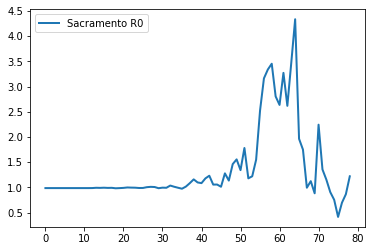

In [65]:
import PIL
import matplotlib.pyplot as plt

x = range(len(R0_Sacramento))
y1 = R0_Sacramento
# y2 = R0_NYC
plt.plot(x, y1, ls="-", lw=2, label="Sacramento R0")
# plt.plot(x, y2, ls="-", lw=2, label="NYC R0")
# plt.ylim(0,3)
plt.legend()
plt.show()

In [66]:
pred_vals = []
for i in range(79):
    pred_vals.append(train_vals[i][202].cpu().numpy())

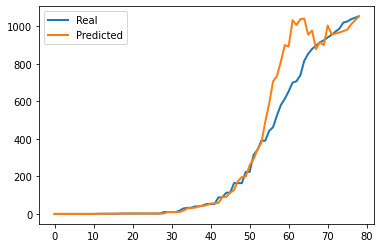

In [69]:
x = range(79)
y1 = train_labels
y2 = pred_vals
plt.plot(x, y1, ls="-", lw=2, label="Real")
plt.plot(x, y2, ls="-", lw=2, label="Predicted")
plt.legend()
plt.show()

## GAT - SIR

In [39]:
hidden_size = 100
learning_rate = 0.0000005
num_epochs = 1000
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases[0].shape[1] + attrs.shape[1]
net_sir = GAT_SIR(g, input_size, hidden_size, output_size, 1)
print('#features:', input_size)

# Move model to GPU
net_sir = net_sir.to(device)

# Move data to GPU
pop = pop.to(device)
attrs = attrs.to(device)
for i in range(len(train_past_cases)):
    train_past_cases[i] = train_past_cases[i].to(device)
    train_past_deaths[i] = train_past_deaths[i].to(device)
    train_labels_cases[i] = train_labels_cases[i].to(device)
    if len(train_labels_cases[i].shape) == 1:
        train_labels_cases[i] = train_labels_cases[i].unsqueeze(1)
    if len(train_labels_deaths[i].shape) == 1:
        train_labels_deaths[i] = train_labels_deaths[i].unsqueeze(1)
for i in range(len(valid_past_cases)):
    valid_past_cases[i] = valid_past_cases[i].to(device)
    valid_past_deaths[i] = valid_past_deaths[i].to(device)
    valid_labels_cases[i] = valid_labels_cases[i].to(device)
    if len(valid_labels_cases[i].shape) == 1:
         valid_labels_cases[i] = valid_labels_cases[i].unsqueeze(1)
    if len(test_labels_deaths[i].shape) == 1:
        valid_labels_deaths[i] = valid_labels_deaths[i].unsqueeze(1)

for i in range(len(test_past_cases)):
    test_past_cases[i] = test_past_cases[i].to(device)
    test_past_deaths[i] = test_past_deaths[i].to(device)
    test_labels_cases[i] = test_labels_cases[i].to(device)
    if len(test_labels_cases[i].shape) == 1:
        test_labels_cases[i] = test_labels_cases[i].unsqueeze(1)
    if len(test_labels_deaths[i].shape) == 1:
        test_labels_deaths[i] = test_labels_deaths[i].unsqueeze(1)
        
# Normalize attrs
attrs[th.isnan(attrs)] = 0
attr_mean = th.mean(attrs, dim=1, keepdim=True)
attrs = attrs - attr_mean
attr_std = th.std(attrs, dim=1, keepdim=True)
attrs = attrs / attr_std

optimizer = th.optim.Adam(net_sir.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    # sample_idxs = th.randperm(len(train_past_cases))
    losses = []
    for idx in range(len(train_past_cases)):
        labels = train_labels_cases[idx]
        batch = th.cat([train_past_cases[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = net_sir(batch)
        I = train_past_cases[idx][:,-1].view(3142,1)
        D = train_past_deaths[idx][:,-1].view(3142,1)
        # loss = sir_loss(vals, I, D, labels)
        output = sir_1d_output(vals, I, D, labels)
        loss = my_msle(output, labels)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    
    count = 0
    with th.no_grad():
        eval_errs = []
        for idx in range(6):
            valid_feats = th.cat([valid_past_cases[idx], attrs], dim=1)
            eval_vals = net_sir(valid_feats)
            eval_I = valid_past_cases[idx][:,-1].view(3142,1)
            eval_D = valid_past_deaths[idx][:,-1].view(3142,1)
            eval_labels = valid_labels_cases[idx]
            eval_output = sir_1d_output(eval_vals, eval_I, eval_D, eval_labels)
            err = my_msle(eval_output, eval_labels)
            eval_errs.append(err.cpu().numpy())
            
        if np.mean(eval_errs) <= 0.008:
            R0_NYC = []
            R0_Sacramento = []
            gamma_NYC = []
            beta_NYC = []
            gamma_Sacramento = []
            beta_Sacramento = []
            train_vals = []
            for idx in range(len(train_past_cases)):
                labels = train_labels_cases[idx]
                batch = th.cat([train_past_cases[idx], attrs], dim=1)
                th.manual_seed(1)
                vals = mlp_sir(batch)
                gamma_NYC.append(vals[4][0])
                gamma_Sacramento.append(vals[202][0])
                beta_NYC.append(vals[4][0])
                beta_Sacramento.append(vals[202][0])
                R_NYC_div = th.div(vals[4][1],vals[4][0])
                R_Sacramento_div = th.div(vals[202][1],vals[202][0])
                R0_NYC.append(R_NYC_div)
                R0_Sacramento.append(R_Sacramento_div)
                I = train_past_cases[idx][:,-1].view(3142,1)
                D = train_past_deaths[idx][:,-1].view(3142,1)
                output = sir_1d_output(vals, I, D, labels)
                train_vals.append(output)
            break
    print('epoch={}, loss={:.3f}, validation loss = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs)))

#features: 97
epoch=0, loss=0.064, validation loss = 0.124
epoch=1, loss=0.026, validation loss = 0.021
epoch=2, loss=0.023, validation loss = 0.012
epoch=3, loss=0.021, validation loss = 0.010
epoch=4, loss=0.020, validation loss = 0.010
epoch=5, loss=0.020, validation loss = 0.010
epoch=6, loss=0.019, validation loss = 0.010
epoch=7, loss=0.019, validation loss = 0.009
epoch=8, loss=0.019, validation loss = 0.009
epoch=9, loss=0.018, validation loss = 0.009
epoch=10, loss=0.018, validation loss = 0.009
epoch=11, loss=0.018, validation loss = 0.009
epoch=12, loss=0.018, validation loss = 0.009
epoch=13, loss=0.018, validation loss = 0.009
epoch=14, loss=0.018, validation loss = 0.008
epoch=15, loss=0.018, validation loss = 0.008
epoch=16, loss=0.018, validation loss = 0.008
epoch=17, loss=0.018, validation loss = 0.008


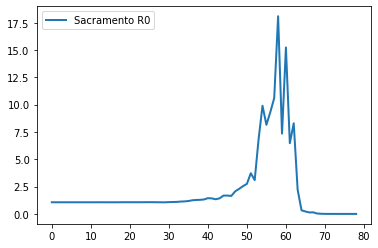

In [46]:
x = range(len(R0_Sacramento))
y = R0_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Sacramento R0")
plt.legend()
plt.show()

In [45]:
pred_vals = []
for i in range(79):
    pred_vals.append(train_vals[i][202].cpu().numpy())

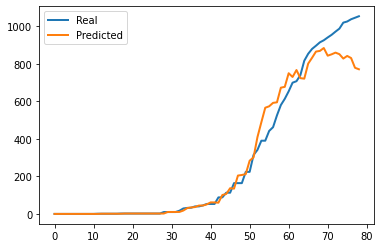

In [50]:
x = range(79)
y1 = train_vals
y2 = pred_vals
plt.plot(x, y1, ls="-", lw=2, label="Real")
plt.plot(x, y2, ls="-", lw=2, label="Predicted")
plt.legend()
plt.show()